# **Library**

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import math
import random
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# **SAM**

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g1_jqhhq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g1_jqhhq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=1e56957157df8fa82442e43e7838d8669e0501b7214814fae364891ba5e436c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-nhpikseu/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-16 12:29:58--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.15, 

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

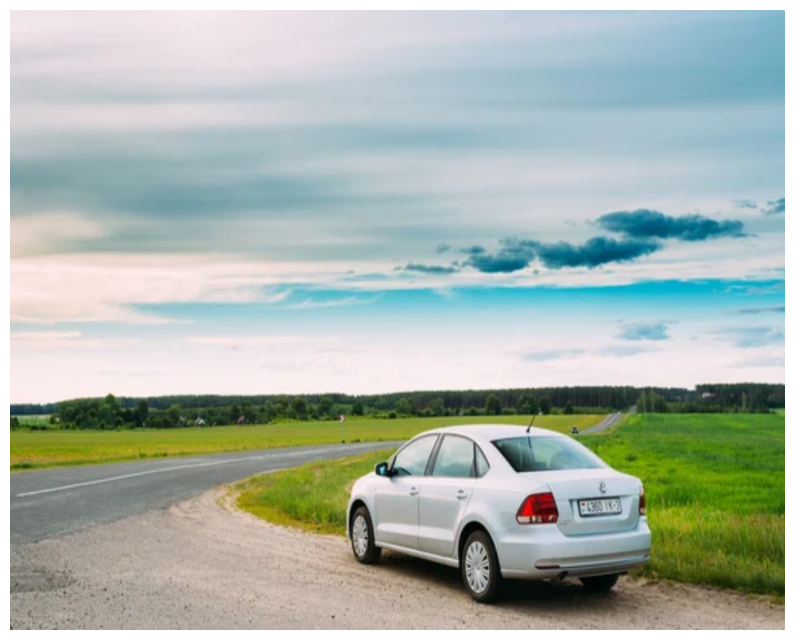

In [ ]:
# Path to your image file
image_path = '/content/drive/MyDrive/Master Class/images/Car.jpg'

# Load and display the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0, 0), fx = 1000/image.shape[1], fy = 800/image.shape[0])

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
import sys
sys.path.append("..")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

62
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


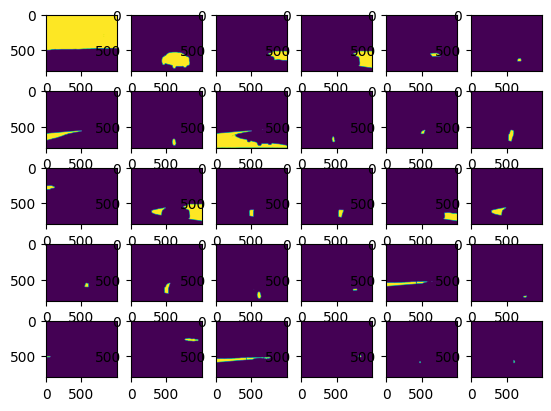

In [ ]:
for i in range(30):
  plt.subplot(5,6,i+1)
  plt.imshow(masks[i+1]["segmentation"])

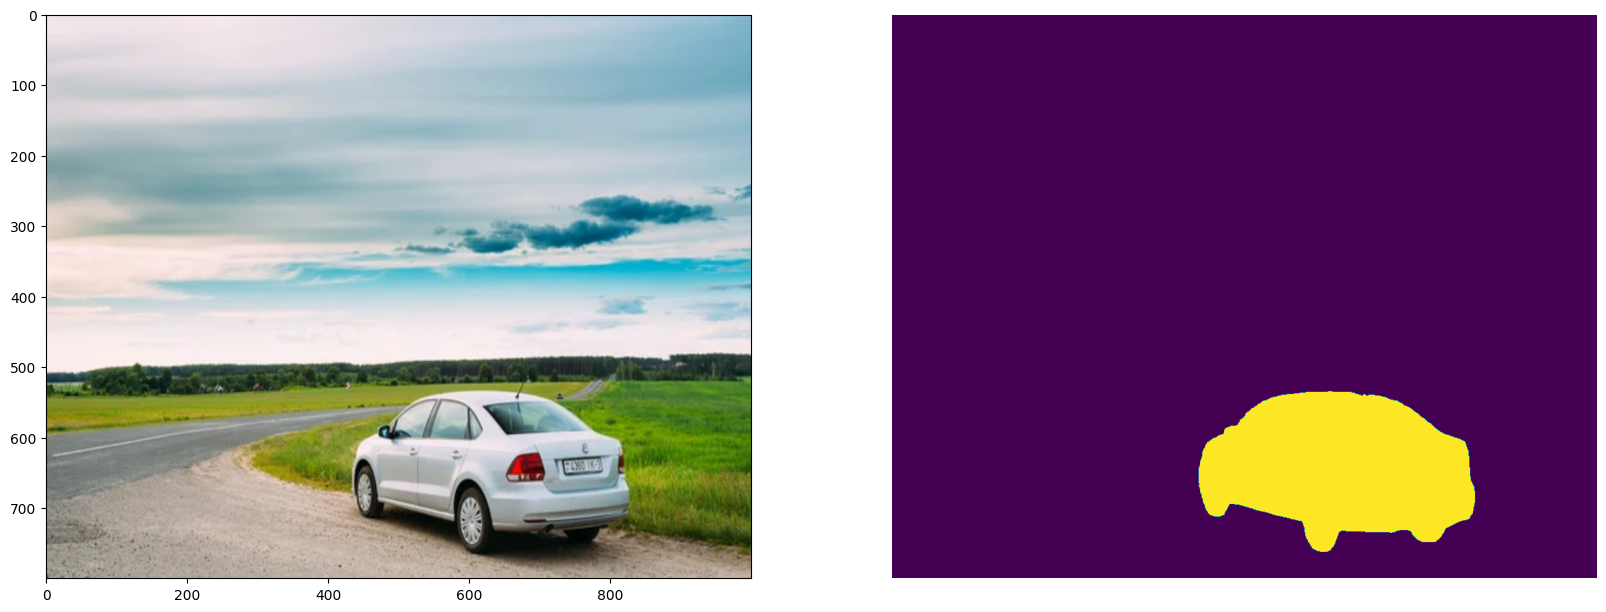

[435, 535, 391, 227]


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)

idx = 2
plt.subplot(1,2,2)
plt.imshow(masks[idx]["segmentation"])
plt.axis('off')
plt.show()
image.shape
print(masks[idx]["bbox"])

In [ ]:
#for all masks
mask_list=[]
for i in range(len(masks)):
  mask_list.append(masks[i]["segmentation"])


seg_obj_list=[]
for mask in mask_list:

  pixel_list=[]
  for i in range(len(image)):
    for j in range (len(image[i])):
      if(mask[i][j]==False):
        pixel_list.append([255,255,255])
      else:
        pixel_list.append(image[i][j])

  segmented_obj = np.array(pixel_list).reshape(len(image),len(image[0]),3)
  seg_obj_list.append(segmented_obj)

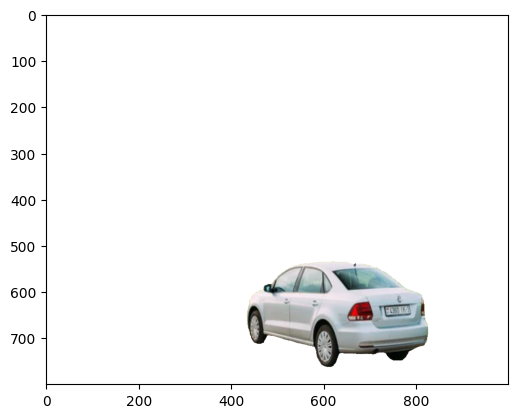

In [ ]:
plt.imshow(seg_obj_list[2])

# **Missing-pixel-filler**

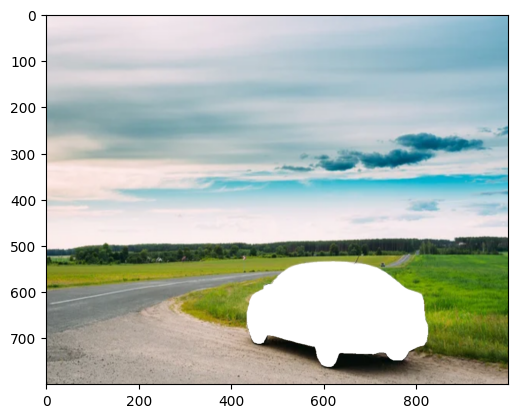

In [ ]:
car_mask = masks[2]["segmentation"]
pixel_list=[]
for i in range(len(image)):
  for j in range (len(image[i])):
    if(car_mask[i][j]==True):
      pixel_list.append([255,255,255])
    else:
      pixel_list.append(image[i][j])

segmented_obj = np.array(pixel_list).reshape(len(image),len(image[0]),3)
plt.imshow(segmented_obj)

In [ ]:
seg_obj_list[2].shape

(800, 1000, 3)

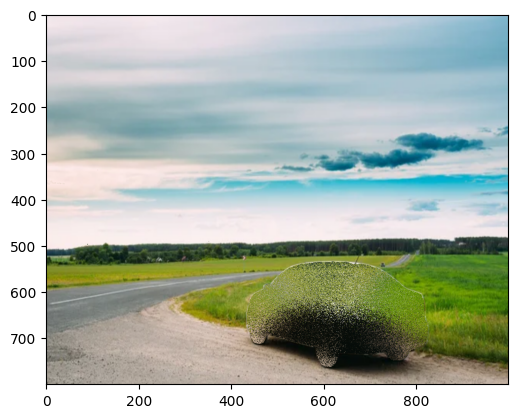

In [ ]:
def get_neighboring_pixel(img, x, y):
  x_rand, y_rand = 0,0

  max_num_tries = 30
  max_tries_per_neighbourhood = 5
  neighbourhood_size_increment = 30
  current_window_size = 30
  total_tries = 3
  for _ in range(math.ceil(max_num_tries/max_tries_per_neighbourhood)):
    for _ in range(max_tries_per_neighbourhood):
      min_x = max(0, x-current_window_size)
      max_x = min(800, x+current_window_size)
      min_y = max(0, y-current_window_size)
      max_y = min(1000, y+current_window_size)
      x_rand = random.randint(min_x, max_x-1)
      y_rand = random.randint(min_y, max_y-1)
      total_tries += 1
      if not(img[x_rand][y_rand][0]==0 and img[x_rand][y_rand][1]==0 and img[x_rand][y_rand][2]==0):
          return x_rand, y_rand
    current_window_size += neighbourhood_size_increment

  return x_rand, y_rand

def fill_swath_with_neighboring_pixel(img):
  img_with_neighbor_filled = img.copy()
  (x_swath, y_swath, z_swath) = np.where(img == [255, 255, 255])
  #print((x_swath, y_swath, z_swath))

  for i in range(len(x_swath)):
    x_rand, y_rand = get_neighboring_pixel(img, x_swath[i], y_swath[i])
    img_with_neighbor_filled[x_swath[i]][y_swath[i]] = img[x_rand][y_rand]
  return img_with_neighbor_filled


for i in range(9):

    segmented_obj = fill_swath_with_neighboring_pixel(segmented_obj)

plt.imshow(segmented_obj)

#**CIFAR-10**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Custom dataset class to filter and relabel the classes
class AutomobileDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.automobile_classes = [1, 9]  # Class indices for 'car' and 'truck'

        # Create a mapping of original labels to new binary labels
        self.label_map = {label: 1 if label in self.automobile_classes else 0 for label in range(10)}

        # Filter the dataset to include only automobile and non-automobile samples
        self.indices = [i for i, (_, label) in enumerate(dataset) if label in self.automobile_classes or label not in self.automobile_classes]

    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        label = self.label_map[label]
        return img, label

    def __len__(self):
        return len(self.indices)

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create the automobile datasets
trainset_auto = AutomobileDataset(trainset)
testset_auto = AutomobileDataset(testset)

# Create the data loaders
trainloader = torch.utils.data.DataLoader(trainset_auto, batch_size=6, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_auto, batch_size=6, shuffle=False, num_workers=2)

classes = ('others', 'automobile')

100%|██████████| 170498071/170498071 [00:04<00:00, 40446267.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


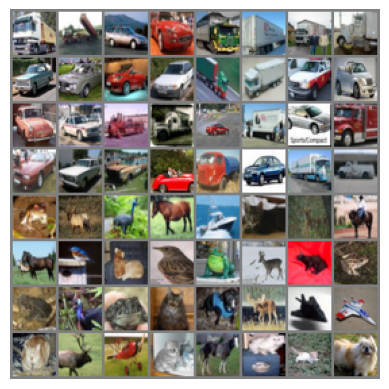

automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile automobile others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others others


In [ ]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Remove axis
    plt.show()

# Get a balanced subset of images from the training set
automobile_indices = [i for i, (_, label) in enumerate(trainset_auto) if label == 1]
other_indices = [i for i, (_, label) in enumerate(trainset_auto) if label == 0]

selected_indices = automobile_indices[:32] + other_indices[:32]
selected_dataset = torch.utils.data.Subset(trainset_auto, selected_indices)

# Create a data loader for the selected images
selected_loader = torch.utils.data.DataLoader(selected_dataset, batch_size=64, shuffle=False)

# Get the selected images and labels
images, labels = next(iter(selected_loader))

# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=8)

# Show the grid of images
imshow(img_grid)

# Print the labels
label_names = ['automobile' if label == 1 else 'others' for label in labels]
print(' '.join('%5s' % label_names[j] for j in range(64)))

**CNN**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Change the output size to 2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # Evaluate the model on the test set after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} Accuracy: {accuracy:.2f}%')

print('Finished Training')

[Epoch 1, Batch 100] Loss: 0.606
[Epoch 1, Batch 200] Loss: 0.572
[Epoch 1, Batch 300] Loss: 0.494
[Epoch 1, Batch 400] Loss: 0.448
[Epoch 1, Batch 500] Loss: 0.441
[Epoch 1, Batch 600] Loss: 0.467
[Epoch 1, Batch 700] Loss: 0.406
[Epoch 1, Batch 800] Loss: 0.428
[Epoch 1, Batch 900] Loss: 0.364
[Epoch 1, Batch 1000] Loss: 0.404
[Epoch 1, Batch 1100] Loss: 0.411
[Epoch 1, Batch 1200] Loss: 0.401
[Epoch 1, Batch 1300] Loss: 0.368
[Epoch 1, Batch 1400] Loss: 0.402
[Epoch 1, Batch 1500] Loss: 0.383
[Epoch 1, Batch 1600] Loss: 0.347
[Epoch 1, Batch 1700] Loss: 0.340
[Epoch 1, Batch 1800] Loss: 0.354
[Epoch 1, Batch 1900] Loss: 0.350
[Epoch 1, Batch 2000] Loss: 0.358
[Epoch 1, Batch 2100] Loss: 0.351
[Epoch 1, Batch 2200] Loss: 0.316
[Epoch 1, Batch 2300] Loss: 0.337
[Epoch 1, Batch 2400] Loss: 0.347
[Epoch 1, Batch 2500] Loss: 0.315
[Epoch 1, Batch 2600] Loss: 0.313
[Epoch 1, Batch 2700] Loss: 0.309
[Epoch 1, Batch 2800] Loss: 0.358
[Epoch 1, Batch 2900] Loss: 0.317
[Epoch 1, Batch 3000] L

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/Master Class/model/trained_model.pth'
torch.save(net.state_dict(), model_path)
print(f'Model saved at: {model_path}')

Model saved at: /content/drive/MyDrive/Master Class/model/trained_model.pth


# **Load the model into all masks**

In [ ]:
car_detect_network = Net()
car_detect_network.load_state_dict(torch.load('/content/drive/MyDrive/Master Class/model/trained_model.pth'))

#test_tensor = torch.rand(3, 32, 32)
#car_detect_network(test_tensor)

<All keys matched successfully>

In [ ]:
image_path = '/content/drive/MyDrive/Master Class/images/612x408.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0, 0), fx = 1000/image.shape[1], fy = 800/image.shape[0])

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [ ]:
# Define the transformation
transform_resize = transforms.Compose([
    transforms.Resize((32, 32))
])

# Select the car mask automatically
car_mask = None
model_inputs = []
for n, mask in enumerate(masks):
    image_tensor = transform(image)
    bb_x = mask['bbox'][0]
    bb_y = mask['bbox'][1]
    bb_w = mask['bbox'][2]
    bb_h = mask['bbox'][3]
    image_crop = transform_resize(image_tensor[:, bb_y : bb_y + bb_h, bb_x : bb_x + bb_w])
    # model_inputs.append(image_crop)

    # segmented_obj[~mask['segmentation']] = [255, 255, 255]
    # segmented_obj_resized = cv2.resize(segmented_obj, (32, 32), interpolation=cv2.INTER_AREA)
    # segmented_obj_pil = Image.fromarray(segmented_obj_resized)
    # segmented_obj_tensor = transform(segmented_obj_pil).unsqueeze(0)
    # model_inputs.append(segmented_obj_tensor)

    output = car_detect_network(image_crop)
    _, predicted = torch.max(output.data, 1)
    if predicted.item() == 1:  # Automobile class
        car_mask = mask['segmentation']
        print(f"found car at position {n}")
        break


# print(len(masks))
# for i in range(len(masks)):
#   plt.subplot(6,11,i+1)
#   plt.axis('off')
#   plt.imshow(model_inputs[i+1].squeeze(0).permute(1, 2, 0))


found car at position 8


In [ ]:
def get_neighboring_pixel(img, x, y):
  x_rand, y_rand = 0,0

  max_num_tries = 30
  max_tries_per_neighbourhood = 5
  neighbourhood_size_increment = 30
  current_window_size = 30
  total_tries = 3
  for _ in range(math.ceil(max_num_tries/max_tries_per_neighbourhood)):
    for _ in range(max_tries_per_neighbourhood):
      min_x = max(0, x-current_window_size)
      max_x = min(800, x+current_window_size)
      min_y = max(0, y-current_window_size)
      max_y = min(1000, y+current_window_size)
      x_rand = random.randint(min_x, max_x-1)
      y_rand = random.randint(min_y, max_y-1)

      total_tries += 1
      if not(img[x_rand][y_rand][0]==0 and img[x_rand][y_rand][1]==0 and img[x_rand][y_rand][2]==0):
          return x_rand, y_rand
    current_window_size += neighbourhood_size_increment

  return x_rand, y_rand

def fill_swath_with_neighboring_pixel(img):
  img_with_neighbor_filled = img.copy()
  (x_swath, y_swath, z_swath) = np.where(img == [255, 255, 255])
  #print((x_swath, y_swath, z_swath))

  for i in range(len(x_swath)):
    x_rand, y_rand = get_neighboring_pixel(img, x_swath[i], y_swath[i])
    img_with_neighbor_filled[x_swath[i]][y_swath[i]] = img[x_rand][y_rand]
  return img_with_neighbor_filled


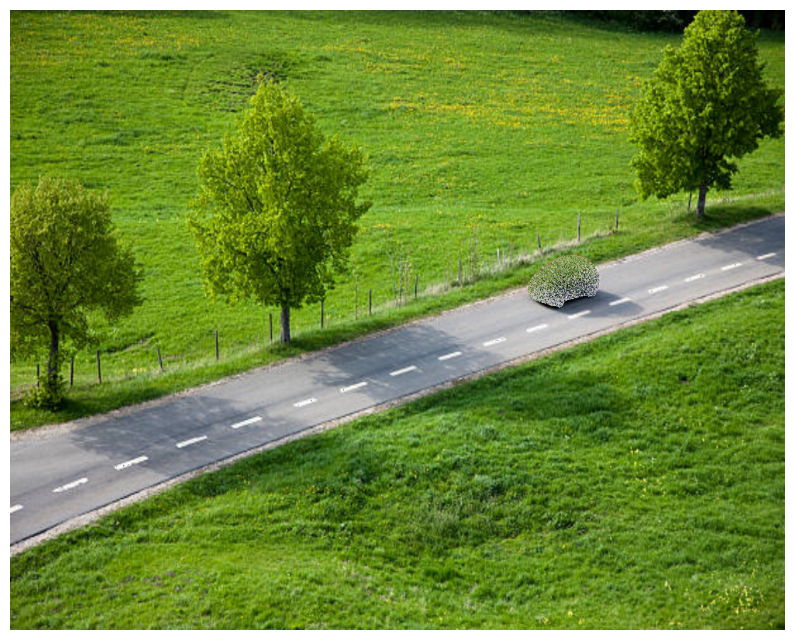

In [ ]:
# Apply the missing pixel filler to repair the image
if car_mask is not None:
    pixel_list = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if car_mask[i][j]:
                pixel_list.append([255, 255, 255])
            else:
                pixel_list.append(image[i][j])

    segmented_obj = np.array(pixel_list).reshape(len(image), len(image[0]), 3)

    for i in range(10):
        segmented_obj = fill_swath_with_neighboring_pixel(segmented_obj)

    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_obj)
    plt.axis('off')
    plt.show()
else:
    print("No car detected in the image.")